In [3]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [4]:
import torch
import seaborn as sns
import ristretto.activations as ra
import ristretto.models as rm
import ristretto.utils as ru
import pandas as pd
import numpy as np
# from torch.utils.tensorboard import SummaryWriter

In [5]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float32)

In [6]:
@torch.no_grad()
def get_weight_sum(model):
    return sum([x.weight.sum() for x in model.linear]).item()

def get_weight_grad(model):
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    return grads

In [7]:
depths  = [1, 2, 3, 4]
dims    = [8, 16, 64]
hidden_dims = []

Relus = [ra.ReLU(0), ra.ReLU(1)]#, ra.ReLU(2)]
#Leaky = [ra.ReLU6(0, 0), ra.ReLU6(1,1)]
activations = Relus #+ Leaky

for dim in dims:
    for depth in depths:
        hidden_dims.append([dim] * depth)

new_models = []
for activition in activations:
    for hidden_dim in hidden_dims:
        new_models.append(rm.FullyConnected(activation=lambda: activition, hidden_dims=hidden_dim, seed=42))
    
          
        
models_fully = [
    rm.FullyConnected(activation=lambda: ra.ReLU(0), hidden_dims=hidden_dims[0], seed=42)
    # rm.FullyConnected(activation=lambda: ra.ReLU(0), hidden_dims=hidden_dims[0], seed=42),
    # rm.FullyConnected(activation=lambda: ra.ReLU(1), hidden_dims=hidden_dims[0], seed=42),
    # rm.FullyConnected(activation=lambda: ra.ReLU(0), hidden_dims=[2000], seed=42),
    # rm.FullyConnected(activation=lambda: ra.ReLU(1), hidden_dims=[2000], seed=42)
]

In [8]:
#This is just to know the index of the models for the plots. 
aux = 0
rel = 0 
for activation in activations:
    for dim in dims:
        for depth in depths:
            print(f"index {aux}")
            print(f"Activation: {activation} alpha: {rel}, dim: {dim}, depth: {depth}")
            print(f"Model: {new_models[aux]}")
            aux += 1
    rel += 1

index 0
Activation: ReLU() alpha: 0, dim: 8, depth: 1
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Identity()
    (3): Linear(in_features=8, out_features=10, bias=True)
  )
)
index 1
Activation: ReLU() alpha: 0, dim: 8, depth: 2
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Identity()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Identity()
    (6): Linear(in_features=8, out_features=10, bias=True)
  )
)
index 2
Activation: ReLU() alpha: 0, dim: 8, depth: 3
Model: FullyConnected(
  (sequence): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Identity()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Identity()
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): ReLU()
    (8): Id

In [9]:
# # train_multiple_models(models, data_loader, epochs=10,
#     optimizer_fn=_optim.Adam,optimizer_kwargs={}, criterion=_F.cross_entropy,
#     device=_default.DEVICE, metrics_fn=None, verbose=False )
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



metrics = ru.train_multiple_models(
    #new_models,
    models_fully,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=20,
    # m is the model, p is the prediction, y is the target
    metrics_fn=lambda m, p, y: {"weight_sum": get_weight_sum(m), "grad": get_weight_grad(m)}
)

===== Model 1 (FullyConnected) =====
---------- Epoch  1 ----------
Validation
    loss:     4.002e-01
    accuracy: 88.07
---------- Epoch  2 ----------
Validation
    loss:     3.526e-01
    accuracy: 89.48
---------- Epoch  3 ----------
Validation
    loss:     3.372e-01
    accuracy: 90.02
---------- Epoch  4 ----------
Validation
    loss:     3.293e-01
    accuracy: 90.43
---------- Epoch  5 ----------
Validation
    loss:     3.244e-01
    accuracy: 90.59
---------- Epoch  6 ----------
Validation
    loss:     3.214e-01
    accuracy: 90.77
---------- Epoch  7 ----------
Validation
    loss:     3.193e-01
    accuracy: 90.82
---------- Epoch  8 ----------
Validation
    loss:     3.170e-01
    accuracy: 91.06
---------- Epoch  9 ----------
Validation
    loss:     3.156e-01
    accuracy: 91.08
---------- Epoch 10 ----------
Validation
    loss:     3.141e-01
    accuracy: 91.08
---------- Epoch 11 ----------
Validation
    loss:     3.126e-01
    accuracy: 91.05
---------- Epoch 

In [11]:
metrics[0]['train']['grad'].sum()

tensor([ 0.0000,  0.0000,  0.0000,  ...,  1.4536, 36.4213, -7.0217],
       device='cuda:0')

In [37]:
import pickle

# with open("output.bin", "wb") as output:
#     pickle.dump(yourList, output)
    

# with open("output.bin", "rb") as data:
#     yourList = pickle.load(data)

with open("output1.bin", "wb") as output: #Im storing the esperiment results for further testing 
    pickle.dump(metrics, output)
    output.close()

In [ ]:
metrics = ru.train_multiple_models(
    new_models,
    #models_fully,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=20,
    metrics_fn=lambda m, p, y: {"weight_sum": get_weight_sum(m)},
    device=DEVICE,
)

In [38]:
print("numbers models: ",len(metrics),"Which contain: ")
print(metrics[0].keys())
print('train contains: ')
print(metrics[0]['train'].keys()) 
print('validation contains: ')
print(metrics[0]['validation'].keys()) 


numbers models:  12 Which contain: 
dict_keys(['train', 'validation'])
train contains: 
Index(['loss', 'accuracy', 'weight_sum'], dtype='object')
validation contains: 
Index(['loss', 'correct', 'weight_sum'], dtype='object')


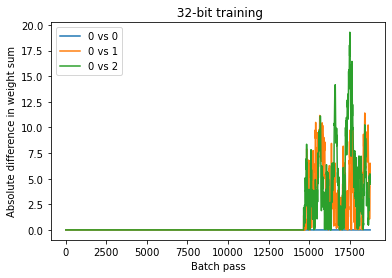

In [41]:
import matplotlib.pyplot as plt

diff = pd.DataFrame({
    "0 vs 0": np.abs(metrics[0]["train"]['weight_sum'] - metrics[0]["train"]['weight_sum']),
    "0 vs 1": np.abs(metrics[0]["train"]['weight_sum'] - metrics[4]["train"]['weight_sum']),
    "0 vs 2": np.abs(metrics[0]["train"]['weight_sum'] - metrics[8]["train"]['weight_sum']),
})

sns.lineplot(data=diff, dashes=False);
plt.title(" 32-bit training")
plt.xlabel("Batch pass")
plt.ylabel("Absolute difference in weight sum");

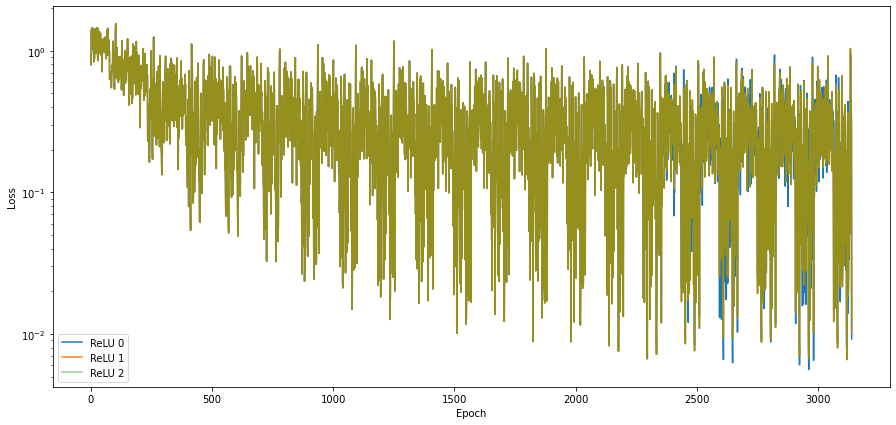

In [49]:
fig = plt.figure(figsize=(15, 7))
plt.plot(metrics[0]["validation"]['loss'], label='ReLU 0')
plt.plot(metrics[4]["validation"]['loss'], label='ReLU 1')
plt.plot(metrics[4]["validation"]['loss'], label='ReLU 2', alpha = 0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')

### When trained with 16-bit precision the difference between the models is even greater

In [56]:
# set pytorch precision
torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.bfloat16)

In [57]:
depths  = [10, 20]
dims    = [20, 50]
hidden_dims = []

Relus = [ra.ReLU(0), ra.ReLU(1), ra.ReLU(2)]
#Leaky = [ra.ReLU6(0, 0), ra.ReLU6(1,1)]
activations = Relus #+ Leaky

for dim in dims:
    for depth in depths:
        hidden_dims.append([dim] * depth)

new_models_16 = []
for activition in activations:
    for hidden_dim in hidden_dims:
        new_models_16.append(rm.FullyConnected(activation=lambda: activition, hidden_dims=hidden_dim, seed=42))
    
        
# models = [
#     rm.FullyConnected(activation=lambda: ra.ReLU(0), hidden_dims=[2000], seed=42),
#     rm.FullyConnected(activation=lambda: ra.ReLU(0), hidden_dims=[2000], seed=42),
#     rm.FullyConnected(activation=lambda: ra.ReLU(1), hidden_dims=[2000], seed=42)
# ]

In [58]:
metrics_16 = ru.train_multiple_models(
    new_models_16,
    ru.default.DATA_LOADERS['MNIST'],
    epochs=2,
    metrics_fn=lambda m, p, y: {"weight_sum": get_weight_sum(m)}
)

===== Model  1 (FullyConnected) =====
---------- Epoch 1 ----------
Validation
    loss:     1.068e+00
    accuracy: 62.21
---------- Epoch 2 ----------
Validation
    loss:     8.886e-01
    accuracy: 73.35

===== Model  2 (FullyConnected) =====
---------- Epoch 1 ----------
Validation
    loss:     2.302e+00
    accuracy: 11.35
---------- Epoch 2 ----------
Validation
    loss:     2.300e+00
    accuracy: 11.35

===== Model  3 (FullyConnected) =====
---------- Epoch 1 ----------
Validation
    loss:     4.581e-01
    accuracy: 87.10
---------- Epoch 2 ----------
Validation
    loss:     3.441e-01
    accuracy: 90.40

===== Model  4 (FullyConnected) =====
---------- Epoch 1 ----------
Validation
    loss:     9.510e-01
    accuracy: 65.04
---------- Epoch 2 ----------
Validation
    loss:     8.144e-01
    accuracy: 75.80

===== Model  5 (FullyConnected) =====
---------- Epoch 1 ----------
Validation
    loss:     1.128e+00
    accuracy: 58.19
---------- Epoch 2 ----------
Validation


In [8]:
import pickle
import matplotlib.pyplot as plt

with open("output1_16.bin", "rb") as data:
    metrics_16 = pickle.load(data)

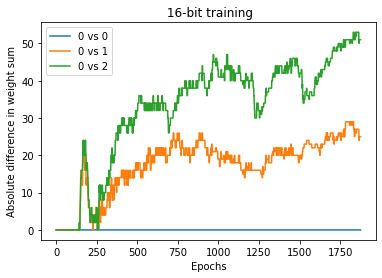

In [9]:

diff = pd.DataFrame({
    "0 vs 0": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[0]["train"]['weight_sum']),
    "0 vs 1": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[4]["train"]['weight_sum']),
    "0 vs 2": np.abs(metrics_16[0]["train"]['weight_sum'] - metrics_16[8]["train"]['weight_sum']),
})
sns.lineplot(data=diff, dashes=False);
plt.title(" 16-bit training");
plt.xlabel("Epochs");
plt.ylabel("Absolute difference in weight sum");

In [60]:
with open("output1_16.bin", "wb") as output: #Im storing the esperiment results for further testing 
    pickle.dump(metrics_16, output)
    output.close()